In [1]:
"""
Two-Stage-To-Orbit Design Problem with Environmental Optimization
Modified to minimize Life Cycle Assessment (LCA) score instead of GLOW

L. BREVAULT (ONERA/DTIS), M. BALESDENT (ONERA/DTIS)
Modified for environmental optimization
"""

import numpy as np
import pandas as pd
import sys
np.set_printoptions(threshold=sys.maxsize)
from matplotlib import pyplot as plt

# Import OpenMDAO + CMA-ES optimization algorithm
import openmdao.api as om
import cma

# Import specific Python functions for launch vehicle design
import Launch_vehicle_Group
import post_traitement
import result_vizualization
import constants as Cst
import specifications as Spec

✓ Brightway2 and ecoinvent successfully loaded


In [2]:
# Create an OpenMDAO problem using the launch vehicle group with LCA
P_obj = om.Problem()
P_obj.model = Launch_vehicle_Group.Launcher_vehicle()
P_obj.setup()

In [3]:
# Fixed Point Iteration for single evaluation
def FPI(Pb):
    """
    Fixed Point Iteration for solving the coupled system
    """
    Pb.setup(check=False)
    
    # Set default values
    Pb['Diameter_stage_1'] = 5.0
    Pb['Diameter_stage_2'] = 5.0
    Pb['Mass_flow_rate_stage_1'] = 250.
    Pb['Mass_flow_rate_stage_2'] = 250.
    Pb['Thrust_stage_1'] = 1000.
    Pb['Thrust_stage_2'] = 800.
    Pb['OF_stage_1'] = 5.0
    Pb['OF_stage_2'] = 5.0
    Pb['Pc_stage_1'] = 100.0
    Pb['Pc_stage_2'] = 100.0
    Pb['Pe_stage_1'] = 1.0
    Pb['Pe_stage_2'] = 1.0
    Pb['N_eng_stage_1'] = 8.
    Pb['N_eng_stage_2'] = 1.
    Pb['Prop_mass_stage_1'] = 320000.
    Pb['Prop_mass_stage_2'] = 75000.
    Pb['thetacmd_i'] = 2.72
    Pb['thetacmd_f'] = 10.
    Pb['ksi'] = 0.293
    Pb['Pitch_over_duration'] = 5.
    Pb['Exit_nozzle_area_stage_1'] = 0.79
    Pb['Exit_nozzle_area_stage_2'] = 3.6305
    Pb['Delta_vertical_phase'] = 10.
    Pb['Delta_theta_pitch_over'] = 1.        
    Pb['command_stage_1_exo'] = np.array([30.,-20.])
    Pb['is_fallout'] = 0.
    
    # NEW: Set default material compositions (50/50 mix)
    Pb['k_SM_thrust_frame'] = 0.81  # 50% Al, 50% Composite for thrust frame
    Pb['k_SM_interstage'] = 0.85    # 50% Al, 50% Composite for interstage

    # Fixed point iteration
    error = 100.
    Pb['Pdyn_max_dim'] = 40.
    k = 0
    while error > 1. and k < 20:
        Pb.run_model()
        error = abs(Pb['Pdyn_max_dim'] - Pb['max_pdyn_load_ascent_stage_1']/1e3)
        Pb['Pdyn_max_dim'] = Pb['max_pdyn_load_ascent_stage_1']/1e3
        k = k + 1
        print(f'Fixed Point Iteration: {k}, error: {np.round(error[0],2)}, '
              f'Input pdyn max (kPa): {np.round(Pb["Pdyn_max_dim"][0],2)}')
    return Pb


In [4]:
# FPI for optimization with material variables
def FPI_optim(x, lowerbnd_exp, upperbnd_exp, Pb):
    """
    Fixed Point Iteration for optimization including material composition variables
    """
    Pb.setup(check=False)
    XX = lowerbnd_exp + (upperbnd_exp - lowerbnd_exp)*x
    
    # Fixed parameters
    Pb['Diameter_stage_1'] = 5.0
    Pb['Diameter_stage_2'] = 5.0
    Pb['Mass_flow_rate_stage_1'] = 300.
    Pb['Mass_flow_rate_stage_2'] = 200.
    Pb['Thrust_stage_1'] = 1000.
    Pb['Thrust_stage_2'] = 1000.
    Pb['OF_stage_1'] = 5.
    Pb['OF_stage_2'] = 5.5
    Pb['Pc_stage_1'] = 80.0
    Pb['Pc_stage_2'] = 60.0
    Pb['Pe_stage_1'] = 1.0
    Pb['Pe_stage_2'] = 1.0
    Pb['N_eng_stage_1'] = 6.
    Pb['N_eng_stage_2'] = 1.
    
    # Design variables from optimization
    Pb['Prop_mass_stage_1'] = XX[0]*1e3
    Pb['Prop_mass_stage_2'] = XX[1]*1e3
    Pb['thetacmd_i'] = XX[2]
    Pb['thetacmd_f'] = XX[3] 
    Pb['ksi'] = XX[4]
    Pb['Pitch_over_duration'] = XX[5]
    Pb['Delta_vertical_phase'] = XX[6]
    Pb['Delta_theta_pitch_over'] = XX[7]        
    Pb['command_stage_1_exo'] = XX[8:10]
    
    # NEW: Material composition design variables
    Pb['k_SM_thrust_frame'] = XX[10]
    Pb['k_SM_interstage'] = XX[11]
    
    # Fixed parameters
    Pb['Exit_nozzle_area_stage_1'] = 0.79
    Pb['Exit_nozzle_area_stage_2'] = 3.6305
    Pb['is_fallout'] = 0.

    # Fixed point iteration
    error = 100.
    Pb['Pdyn_max_dim'] = 40.
    k = 0
    while error > 1. and k < 20:
        Pb.run_model()
        error = abs(Pb['Pdyn_max_dim'] - Pb['max_pdyn_load_ascent_stage_1']/1e3)
        Pb['Pdyn_max_dim'] = Pb['max_pdyn_load_ascent_stage_1']/1e3
        k = k + 1
    return Pb

In [5]:
# Environmental Objective Function
def Objective_function_LCA(x, lowerbnd_exp, upperbnd_exp, Pb, simu):
    """
    Objective function for environmental optimization
    Minimizes LCA score while respecting all trajectory constraints
    """
    P_out = FPI_optim(x, lowerbnd_exp, upperbnd_exp, Pb)
    GLOW, contraintes = post_traitement.post_traitement(P_out)
    LCA_score = P_out['Environmental.LCA_score'][0]
    
    if simu == 0:  # Optimization mode
        if len(np.where(contraintes > 1e-2)[0]) == 0:
            # All constraints satisfied - minimize LCA score
            # Scale LCA score for optimizer (assuming typical values 1e5-1e6)
            return LCA_score / 1e5
        else:
            # Constraints not satisfied - minimize constraint violation
            cont = np.sum(contraintes[np.where(contraintes > 0)[0]])
            return 1000 + cont  # Large penalty for constraint violations
    else:  # Evaluation mode
        if len(np.where(contraintes > 1e-2)[0]) == 0:
            return LCA_score, GLOW, -5  # Return both LCA and GLOW for analysis
        else:
            return LCA_score, GLOW, contraintes

In [6]:
# Multi-objective function (optional - for Pareto front analysis)
def Objective_function_multiobjective(x, lowerbnd_exp, upperbnd_exp, Pb, w_lca=0.7, w_glow=0.3):
    """
    Multi-objective function balancing LCA and GLOW
    w_lca: weight for LCA score (default 0.7)
    w_glow: weight for GLOW (default 0.3)
    """
    P_out = FPI_optim(x, lowerbnd_exp, upperbnd_exp, Pb)
    GLOW, contraintes = post_traitement.post_traitement(P_out)
    LCA_score = P_out['Environmental.LCA_score'][0]
    
    if len(np.where(contraintes > 1e-2)[0]) == 0:
        # Normalize objectives (typical ranges)
        LCA_norm = LCA_score / 1e6  # Assuming LCA ~1e6
        GLOW_norm = GLOW / 5e5      # Assuming GLOW ~500 tonnes
        
        # Weighted sum
        obj = w_lca * LCA_norm + w_glow * GLOW_norm
        return obj
    else:
        # Constraints not satisfied
        cont = np.sum(contraintes[np.where(contraintes > 0)[0]])
        return 1000 + cont

In [7]:
# Define bounds for design variables including material compositions
lowerbnd_exp = np.array([
    150.,   # Prop_mass_stage_1 (tonnes)
    20.,    # Prop_mass_stage_2 (tonnes)
    0.,     # theta_cmd_i
    -10.,   # theta_cmd_f
    -1.,    # ksi
    5.,     # Pitch_over_duration
    5.,     # Delta_vertical_phase
    1.,     # Delta_theta_pitch_over
    10., 10.,  # command_stage_1_exo (2 values)
    0.62,   # k_SM_thrust_frame (min = 100% Composite)
    0.7     # k_SM_interstage (min = 100% Composite)
])

upperbnd_exp = np.array([
    600.,   # Prop_mass_stage_1 (tonnes)
    200.,   # Prop_mass_stage_2 (tonnes)
    50.,    # theta_cmd_i
    20.,    # theta_cmd_f
    1.,     # ksi
    20.,    # Pitch_over_duration
    20.,    # Delta_vertical_phase
    10.,    # Delta_theta_pitch_over
    70., 70.,  # command_stage_1_exo (2 values)
    1.0,    # k_SM_thrust_frame (max = 100% Aluminum)
    1.0     # k_SM_interstage (max = 100% Aluminum)
])

In [ ]:
import numpy as np
import pandas as pd

# --- tiny accessor: bracket-only, no .get(), returns a plain float ---
def v(name, default=0.0):
    try:
        arr = np.asarray(P_out[name]).ravel()
        return float(arr[0]) if arr.size else float(default)
    except Exception:
        return float(default)

# ===== baseline summary table (CO2 in tonnes, LCA in Pt) =====
data = [[
    v('GLOW')/1e3,
    v('Dry_mass_stage_1')/1e3,
    v('Dry_mass_stage_2')/1e3,
    v('Prop_mass_stage_1')/1e3,
    v('Prop_mass_stage_2')/1e3,
    v('Environmental.LCA_score'),          # Pt (no hidden scaling)
    v('Environmental.CO2_eq')/1000.0       # kg -> t
]]
df = pd.DataFrame(data, columns=[
    "GLOW (t)", "Dry_mass_1 (t)", "Dry_mass_2 (t)",
    "Prop_mass_1 (t)", "Prop_mass_2 (t)",
    "LCA Score (Pt)", "CO2 eq (t)"
])
print("\nBaseline Results (fixed units):")
print(df.round(3))

# ===== ESA per-category breakdown =====
ESA_CODES = [
    "GWP","ODEPL","IORAD","PCHEM","PMAT","HTOXnc","HTOXc",
    "ACIDef","FWEUT","MWEUT","TEUT","FWTOX","LUP","WDEPL","ADEPLf","ADEPLmu"
]

rows = []
for code in ESA_CODES:
    rows.append([
        code,
        v(f'Environmental.{code}_impact', 0.0),
        v(f'Environmental.{code}_normalized', 0.0),
        v(f'Environmental.{code}_weighted', 0.0),
    ])

df_cat = pd.DataFrame(rows, columns=["Category","Impact","Normalized","Weighted"])
df_cat["Share_%"] = 100 * df_cat["Weighted"] / max(df_cat["Weighted"].sum(), 1e-12)
df_cat = df_cat.sort_values("Weighted", ascending=False)

print("\nESA per-category (sorted by contribution):")
print(df_cat.round(6))

# sanity check
print(f"\nCheck: sum(weighted) = {df_cat['Weighted'].sum():.6f}  vs  ESA_single_score = {v('Environmental.ESA_single_score'):.6f}")

# ===== stage split (already computed by your component) =====
print("\nStage split (Pt):")
print(f"  Stage 1:     {v('Environmental.LCA_stage_1'):.6f}")
print(f"  Stage 2:     {v('Environmental.LCA_stage_2'):.6f}")
print(f"  Propellants: {v('Environmental.LCA_propellants'):.6f}")

total = max(v('Environmental.LCA_score'), 1e-12)
print("\nShares of total LCA score:")
print(f"  Stage 1:     {100*v('Environmental.LCA_stage_1')/total:5.1f}%")
print(f"  Stage 2:     {100*v('Environmental.LCA_stage_2')/total:5.1f}%")
print(f"  Propellant:  {100*v('Environmental.LCA_propellants')/total:5.1f}%")



Baseline Results (fixed units):
   GLOW (t)  Dry_mass_1 (t)  Dry_mass_2 (t)  Prop_mass_1 (t)  Prop_mass_2 (t)  \
0   440.391          31.463           6.928            320.0             75.0   

   LCA Score (Pt)  CO2 eq (t)  
0        2134.286      4725.1  

ESA per-category (sorted by contribution):
   Category        Impact    Normalized     Weighted    Share_%
15  ADEPLmu  1.269524e+03  19944.224272  1505.788933  70.552350
11    FWTOX  4.079103e+08   9557.338225   183.500894   8.597765
0       GWP  4.725100e+06    583.549795   122.895587   5.758159
8     FWEUT  5.221338e+03   3249.238445    90.978676   4.262722
14   ADEPLf  6.283224e+07    966.359829    80.401138   3.767121
4      PMAT  2.414710e-01    405.670585    36.348084   1.703056
7    ACIDef  2.872710e+04    517.087822    32.059445   1.502116
3     PCHEM  1.626040e+04    400.493634    19.143596   0.896955
13    WDEPL  2.011055e+06    175.343843    14.921761   0.699145
10     TEUT  6.105184e+04    345.431330    12.815502   0


OPTIMIZATION SETUP
Optimizing for minimum LCA score

Starting CMA-ES optimization...
Number of design variables: 12
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 12 (seed=2, Sun Sep 21 14:55:50 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 8.009183060437573e+03 1.0e+00 2.04e-01  2e-01  2e-01 2:13.6
    2     32 8.003241047502306e+03 1.2e+00 1.86e-01  2e-01  2e-01 4:11.0
    3     48 1.009731546013860e+03 1.3e+00 1.87e-01  2e-01  2e-01 5:55.1
    4     64 1.075919802538128e+03 1.3e+00 1.96e-01  2e-01  2e-01 7:57.5
    5     80 1.022323393950461e+03 1.4e+00 2.03e-01  2e-01  2e-01 9:54.8
    6     96 1.009045174208175e+03 1.5e+00 2.06e-01  2e-01  2e-01 11:34.3
    7    112 1.029572041855404e+03 1.6e+00 2.05e-01  2e-01  2e-01 13:13.5
    8    128 1.051430950017795e+03 1.7e+00 2.02e-01  2e-01  2e-01 15:14.3
    9    144 1.015365524776739e+03 1.7e+00 1.99e-01  2e-01  2e-01 16:48.4
   10    160 1.031674142703415e+03 1.7e+00 1.92e-01  2e-01  2e-

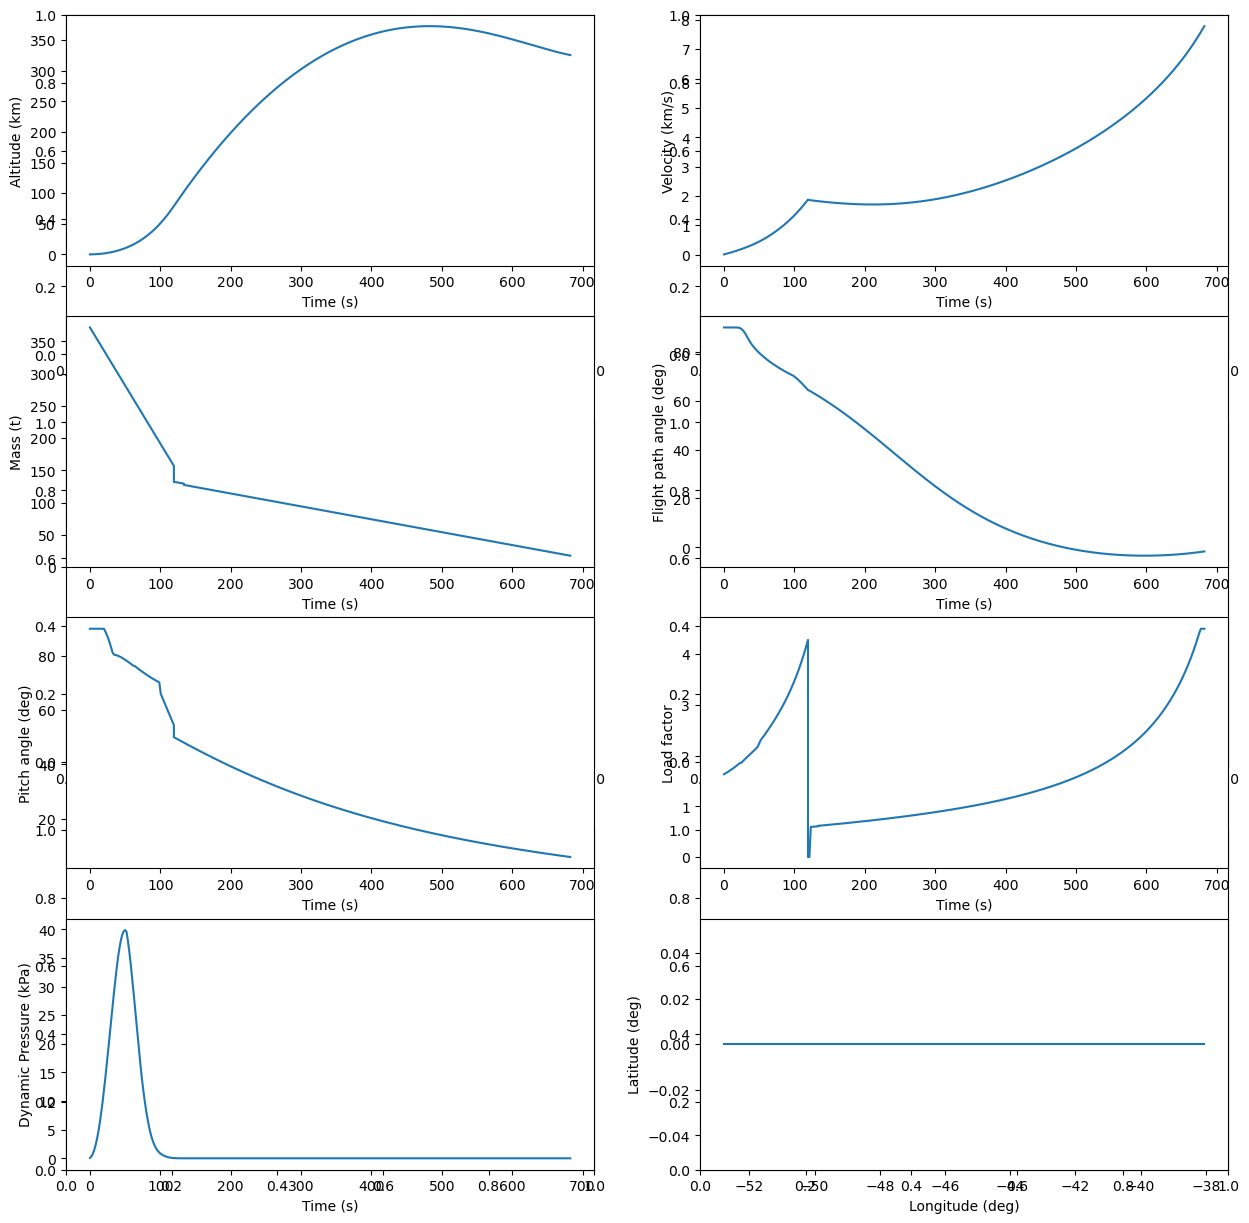

In [14]:
# Setup CMA-ES optimization
print("\n" + "="*60)
print("OPTIMIZATION SETUP")
print("="*60)

# CMA-ES options
lower = np.zeros([1, len(lowerbnd_exp)])
upper = np.ones([1, len(upperbnd_exp)])  
bound_cma = np.array([lower[0], upper[0]])

options = {
    'ftarget': -1e7,       # Target (not used in practice)
    'tolfun': 1e-5,        # Function tolerance
    'tolx': 1e-6,          # Variable tolerance
    'seed': 2,             # Random seed for reproducibility
    'bounds': [bound_cma[0], bound_cma[1]],
    'popsize': 16,         # Increased for more design variables
    'maxiter': 150,        # More iterations for material optimization
    'verb_disp': 1         # Display progress
}

# Choose optimization mode
optimization_mode = input("\nSelect optimization mode:\n"
                         "1. Minimize LCA only\n"
                         "2. Multi-objective (LCA + GLOW)\n"
                         "Enter choice (1 or 2): ")

if optimization_mode == "2":
    w_lca = float(input("Enter LCA weight (0-1, default 0.7): ") or "0.7")
    w_glow = 1.0 - w_lca
    print(f"Using weights: LCA={w_lca:.2f}, GLOW={w_glow:.2f}")
    critere_cma = lambda x: Objective_function_multiobjective(x, lowerbnd_exp, upperbnd_exp, 
                                                             P_obj, w_lca, w_glow)
else:
    print("Optimizing for minimum LCA score")
    simu = 0
    critere_cma = lambda x: Objective_function_LCA(x, lowerbnd_exp, upperbnd_exp, P_obj, simu)

# Initial guess (normalized)
init = np.ones(len(lowerbnd_exp)) * 0.5
# Start with mostly aluminum (conservative)
init[-2] = 0.8  # k_SM_thrust_frame normalized
init[-1] = 0.8  # k_SM_interstage normalized

print("\nStarting CMA-ES optimization...")
print("Number of design variables:", len(lowerbnd_exp))

# Run optimization
res = cma.fmin(critere_cma, init, 0.2, options)

# Results analysis
print("\n" + "="*60)
print("OPTIMIZATION RESULTS")
print("="*60)

print('Optimal design variable values:', res[0])

# Evaluate optimal solution
simu = 1
LCA_opt, GLOW_opt, constraints_check = Objective_function_LCA(res[0], lowerbnd_exp, upperbnd_exp, 
                                                              P_obj, simu)

print(f"\nOptimal LCA Score: {LCA_opt:.2f}")
print(f"Optimal GLOW: {GLOW_opt/1e3:.2f} tonnes")

# Get detailed results
P_out_opt = FPI_optim(res[0], lowerbnd_exp, upperbnd_exp, P_obj)

# Material composition results
XX_opt = lowerbnd_exp + (upperbnd_exp - lowerbnd_exp) * res[0]
k_SM_tf_opt = XX_opt[10]
k_SM_is_opt = XX_opt[11]

al_frac_tf_opt = (k_SM_tf_opt - 0.62) / 0.38
comp_frac_tf_opt = 1.0 - al_frac_tf_opt
al_frac_is_opt = (k_SM_is_opt - 0.7) / 0.3
comp_frac_is_opt = 1.0 - al_frac_is_opt

print(f"\nOptimal Material Composition:")
print(f"Thrust Frame: {al_frac_tf_opt*100:.1f}% Al, {comp_frac_tf_opt*100:.1f}% Composite")
print(f"Interstage: {al_frac_is_opt*100:.1f}% Al, {comp_frac_is_opt*100:.1f}% Composite")

# Detailed results table
data_opt = [[
    P_out_opt['GLOW'][0]/1e3,
    P_out_opt['Dry_mass_stage_1'][0]/1e3,
    P_out_opt['Dry_mass_stage_2'][0]/1e3,
    P_out_opt['Prop_mass_stage_1'][0]/1e3,
    P_out_opt['Prop_mass_stage_2'][0]/1e3,
    P_out_opt['Environmental.LCA_score'][0]/1e3,
    P_out_opt['Environmental.CO2_eq'][0]/1e3,
    P_out_opt['Environmental.Energy_consumption'][0]/1e6
]]

df_opt = pd.DataFrame(data_opt, columns=[
    "GLOW (t)", "Dry_mass_1 (t)", "Dry_mass_2 (t)", 
    "Prop_mass_1 (t)", "Prop_mass_2 (t)",
    "LCA Score", "CO2 eq (t)", "Energy (TJ)"
])

print("\nOptimized Design:")
print(df_opt.round(3))

# Environmental breakdown
print("\n" + "="*60)
print("ENVIRONMENTAL IMPACT BREAKDOWN")
print("="*60)
print(f"Stage 1 LCA: {P_out_opt['Environmental.LCA_stage_1'][0]:.2f}")
print(f"Stage 2 LCA: {P_out_opt['Environmental.LCA_stage_2'][0]:.2f}")
print(f"Propellants LCA: {P_out_opt['Environmental.LCA_propellants'][0]:.2f}")

# Plot results
result_vizualization.plots_output(P_out_opt)

# Save results
results_dict = {
    'design_variables': res[0],
    'GLOW_kg': P_out_opt['GLOW'][0],
    'LCA_score': P_out_opt['Environmental.LCA_score'][0],
    'CO2_eq_kg': P_out_opt['Environmental.CO2_eq'][0],
    'Energy_MJ': P_out_opt['Environmental.Energy_consumption'][0],
    'k_SM_thrust_frame': k_SM_tf_opt,
    'k_SM_interstage': k_SM_is_opt,
    'Al_fraction_thrust_frame': al_frac_tf_opt,
    'Al_fraction_interstage': al_frac_is_opt
}

In [ ]:
# Export to file
import json
with open('optimization_results_LCA.json', 'w') as f:
    json.dump(results_dict, f, indent=2)

print("\nResults saved to 'optimization_results_LCA.json'")

# Compare with baseline
print("\n" + "="*60)
print("IMPROVEMENT FROM BASELINE")
print("="*60)
baseline_lca = P_out['Environmental.LCA_score'][0]
baseline_glow = P_out['GLOW'][0]

lca_reduction = (baseline_lca - P_out_opt['Environmental.LCA_score'][0]) / baseline_lca * 100
glow_change = (P_out_opt['GLOW'][0] - baseline_glow) / baseline_glow * 100

print(f"LCA Reduction: {lca_reduction:.1f}%")
print(f"GLOW Change: {glow_change:+.1f}%")

print("\n" + "="*60)
print("OPTIMIZATION COMPLETE")
print("="*60)